# Deprojection

The observation made in the sky are usually 2D projections of a 3D structure.
A deprojection of this projections is done to infer the 3D structure that can result in such a 2D projection.
The following is a very simple attempt to do so with many simplifying assumptions.

The assumptions:
* Spherical symmetry of the 3D structure
* Intensity in the projection is equal to the distance measure
* Light rays for the projection are coming from a far away uniform backround source
* The projection is centered in the viewing area

Start off with importing the required packages

In [52]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as intg

To test this method, we first have to create a projection to deproject.
This function defines the real radial density profile.

In [53]:
def real_fr(r):
    """
    The real radial density profile
    """

    r0 = 1.0
    rcut = 2.0
    if r < rcut:
        return np.exp(-r/r0)
    else:
        return 0.0

In this function we calculate the distance measure at given position for intensity in the projection

In [54]:
def proj(fr, d, x, y):
    """
    To calculate the projected density value at any given x and y
    """

    R = np.sqrt(x*x+y*y)

    def integ(theta):
        return (R/np.cos(theta)**2) * fr(R/np.cos(theta))

    if R != 0:
        return intg.quad(integ, -np.pi/2, np.arctan(d/R),limit=1000)[0]
    else:
        return 2.0*intg.quad(fr, 0, d,limit=1000)[0]

Here we make image out of projection intensities at different positions. The resolution of this image is limited by the instrument specifications.

In [55]:
def proj_image(N, d_box, D):
    """
    To create the projected density image
    """

    proj_array = np.zeros((N, N), dtype=float)
    i_mid = int(N/2)
    j_mid = int(N/2)
    for i in range(N):
        for j in range(N):
            x = (j-j_mid)*d_box/N
            y = (i_mid-i)*d_box/N

            proj_array[i, j] = proj(real_fr, D, x, y)

    return proj_array

Now, we take this projected image and calculate the projected radial profile.

In [56]:
def proj_r(proj_arr, d_N, d_box):
    """
    To caculate the theta-averaged projection radial profile
    """

    dr = d_box/d_N
    N = np.shape(proj_arr)[0]
    n_r = int(0.5*d_box/dr)
    i_mid = int(N/2)
    j_mid = int(N/2)

    rad_prof = np.zeros(n_r, dtype=float)
    r_arr = np.zeros_like(rad_prof)

    for n in range(n_r-1, -1, -1):
        r_a = dr*n
        r_b = dr*(n+1)

        s = 0.0
        count = 0
        for i in range(N):
            for j in range(N):
                x = (j-j_mid)*d_box/N
                y = (i_mid-i)*d_box/N
                r2 = x*x + y*y

                if r_a*r_a <= r2 < r_b*r_b:
                    s += proj_arr[i, j]
                    count += 1

        if count != 0:
            rad_prof[n] = s/count

        r_arr[n] = (r_b+r_a)*0.5

    return rad_prof, r_arr

Each of this projected intensity value is sum of contribution from different layers. Hence, this can be written as a system of linear equations with the actual radial density values as the variables.

In this function we are calculating the coefficients for one such linear equation.

In [57]:
def eqn_coeff (r_arr,r):

    r_N = np.size(r_arr)

    coeff_list = []

    r_bnd = np.zeros(r_N+1,dtype=float)
    r_bnd[1:r_N+1] = r_arr+0.5*(r_arr[1]-r_arr[0])


    for i in range(r_N,0,-1):

        if r_bnd[i-1]<r:
            if r_bnd[i]>r:
                coeff = 2*( np.sqrt(r_bnd[i]*r_bnd[i] - r*r ) )
            else:
                coeff = 0.0

        else:
            coeff = 2*( np.sqrt(r_bnd[i]*r_bnd[i] - r*r ) - np.sqrt(r_bnd[i-1]*r_bnd[i-1] - r*r ) )

        coeff_list.append(coeff)

    return np.array(coeff_list)

Finally, here we take this system of linear equations and solve it. This gives us the values of actual radial profile.

In [58]:
def deproj(rad_prof, r_arr):
    """
    To calculate the deprojected radial density profile
    """

    coeff_arr = []

    for r in r_arr:

        coeff_arr.append(eqn_coeff(r_arr,r))

    coeff_arr = np.array(coeff_arr)

    rho_dep = np.linalg.solve(coeff_arr,rad_prof)

    return rho_dep[::-1]

### Constants

Here we are defining the constants. Linear pixel density is dependent on the instrument specification. Array size of radial profile should be kept at a value close to linear pixel density to avoid zeros in the profile.

Box length is synonymous to the field of view. Distance of observer should be large enough so that the observer is not inside the feature.

In [59]:
N = 40  # Linear pixel density
d_N = 40 # Double of array size of radial profile
d_box = 6.0  # Box length
D = 10.0  # distance of observer from the feature

### Calculating the projection 
This is obtained by observation.

In [60]:
proj_array = proj_image(N, d_box, D)

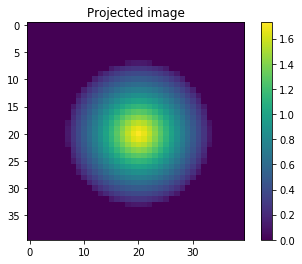

In [61]:
plt.imshow(proj_array)
plt.title("Projected image")
plt.colorbar()

### Calculating the radial profile of projection

In [62]:
proj_prof, r = proj_r(proj_array, d_N, d_box)

Text(0, 0.5, 'Projection intensity')

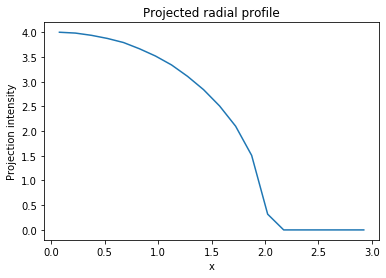

In [63]:
plt.figure()
plt.plot(r, dep)
plt.title("Projected radial profile")
plt.xlabel("x")
plt.ylabel("Projection intensity")

### Calculating the deprojected radial profile

In [64]:
rho_dep = deproj(proj_prof,r)

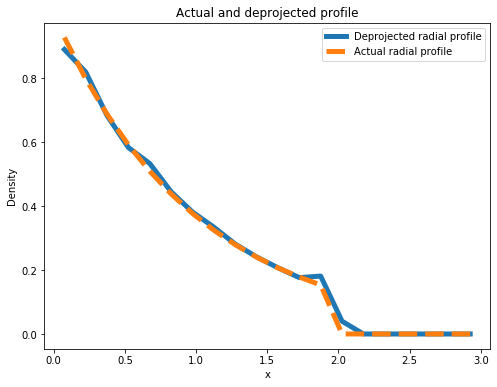

In [65]:
plt.figure(figsize=(8,6))
plt.plot(r, rho_dep, label="Deprojected radial profile",linewidth=5)
plt.plot(r, np.vectorize(real_fr)(r),label="Actual radial profile",linewidth=5,linestyle='dashed')
plt.title("Actual and deprojected profile")
plt.xlabel("x")
plt.ylabel(r"Density")
plt.legend()